In this project we will be analyzing the published data that New York City has on student SAT scores by high school, along with additional demographic data sets. We will be working with various CSV files in a 'school' folder, and seeing as we're working with various data sets, we will be combining all the data in this 'school' folder into a single, clean pandas dataframe. The data cleaning process was done in previous missions, so we'll quickly repeat the process in this notebook and focus on the data analysis.

In [1]:
import pandas as pd
import numpy
import re
import matplotlib

# All the files we want to read in
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for i in data_files:
    # All the datsets are in a folder called 'schools'
    f = pd.read_csv('schools/{0}'.format(i))
    
    # Add each of the dataframes to the dictionary data, using the base of the filename as the key. 
    key_name = i.replace('.csv', '')
    
    # Each key in data should have the corresponding dataframe as its value
    data[key_name] = f

## Reading in the Survey Data

In [2]:
# Need to specify the encoding and delimiter to the pd.read_csv() function to ensure it reads the surveys in properly.
all_survey = pd.read_csv('schools/survey_all.txt', delimiter = '\t', encoding = 'windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter = '\t', encoding = 'windows-1252')

# The code will combine the dataframes by appending d75_survey to the bottom of all_survey, axis(0 = rows, 1 = column)
survey = pd.concat([all_survey, d75_survey], axis = 0, sort = False)

# Change 'dbn' to 'DBN' so it is similar with the format in the 'sat_results' file
survey['DBN'] = survey['dbn']

# Relevant columns from the survey 
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
        "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", 
        "com_tot_11", "eng_tot_11", "aca_tot_11"
       ]
# Add 'survey' as a key and Dataframe as value to the dictionary data
survey = survey[survey_fields]
data['survey'] = survey

print(survey.head(5))

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

      ...      eng_t_11  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0     ...           7.6       7.9       NaN       NaN       NaN       NaN   
1     ...           8.9       9.1       NaN       NaN       NaN       NaN   
2     ...           6.8       7.5       NaN       NaN       NaN       NaN   
3     ...           6.8       7.8       6.2       5.9       6.5       7.4   
4     ...           7.8       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11 

## Add DBN Columns

In [3]:
# Change 'dbn' to 'DBN' so it is similar with the format in the 'sat_results' file
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

# DBN in 'class-size' file is combination of 'CSD' and 'SCHOOL CODE' columns
# DBN padded, so CSD portion always consists of 2 digits
# Need to create function that adds a leading 0 to the CSD if the CSD is less than two digits long.
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return string_representation.zfill(2)

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

## Converting Columns to Numeric

In [4]:
# Create a column that is the total of the SAT scores for different sections of the exam
# Much easier to correlate scores with demographic factors as we'll be working with a single number
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for c in cols:
    # pd.to_numeric converts string to int. Use keyword argument errors = 'coerce' so pandas treats any 
    # invalid strings it cant convert as missing values
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


# We'll want to parse the latitude and longitude coordinates for each school
# Will enable us to map the schools and uncover any geographic patterns in the data
# The coordinates are in the text field Location 1 in the hs_directory data set.
def extract_lat(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def extract_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "")
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(extract_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(extract_lon)

data['hs_directory']['lon'] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")
data['hs_directory']['lat'] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")

## Condensing Datasets

In [5]:
class_size = data['class_size']

# Because we're dealing with high schools, we will filter out everything in 'GRADE ' that isn't '09-12'
# Because GEN ED is the largest program type, let's only select rows where 'PROGRAM TYPE' is 'GEN ED'
class_size = class_size[class_size['GRADE '] == "09-12"]
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# Use DataFrame.groupby() to ensure each value in 'DBN' is unique and agg() method to find mean of each column
class_size = class_size.groupby('DBN').agg(numpy.mean)

# use DataFrame.reset_index() to reset the index to a list of integers and make DBN a column again.
class_size.reset_index(inplace = True)
data['class_size'] = class_size

# The only column that prevents a given DBN from being unique is schoolyear
# Select rows where schoolyear is 20112012, this gives most recent year of data and matches 'sat_results' data
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data.
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006'] # 2006 most recent Cohort
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

## Converting AP Scores to Numeric

In [6]:
# Convert AP Scores to see if there are any correlation with SAT scores across high schools
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors="coerce")

## Combining the Data Sets

In [7]:
combined = data["sat_results"]

# Both the ap_2010 and the graduation data sets have many missing DBN values, so a left join is used to merge with 'sat_results'
combined = combined.merge(data['ap_2010'], how = 'left', on = 'DBN')
combined = combined.merge(data['graduation'], how = 'left', on = 'DBN')

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

# The files in the variable 'to_merge' contain information that's more valuable to our analysisso we'll use an inner join
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

#  fill in the missing values in each column with the mean of that column
combined = combined.fillna(combined.mean())
# fill any NaN or null values that remain after the initial replacement with the value 0
combined = combined.fillna(0)

## Adding a School District Column for Mapping

In [8]:
# Add a column for school districts to carry out mapping the statistics
def first_two_char(dbn):
    name = dbn
    return name[:2]

combined["school_dist"] = combined["DBN"].apply(first_two_char)

## Finding Correlations

In [9]:
correlations = combined.corr()
# Filter to show only correlations of the 'sat_score' column
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.412667
Total Exams Taken                       0.388975
Number of Exams with scores 3 4 or 5    0.382931
CSD                                     0.042948
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent                            -0.398750
sped_num                                0.034933
sped_percent        

## Analysis
Now that we have that data all in one clean combined DataFrame, we can now investigate to see any correlations such as demographic factors such as race, income, and gender have in relation with SAT Scores. This will help us determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

There are several fields in the 'combined' DataFrame that original came from the survey data of parents, teachers and students. We'll make a bar plot to determine if there is any correlation between these fields and SAT Scores. The variable survey_fields has the list of fields we'll investigate. A data dictionary is contained in a school file that is part of the survey data.

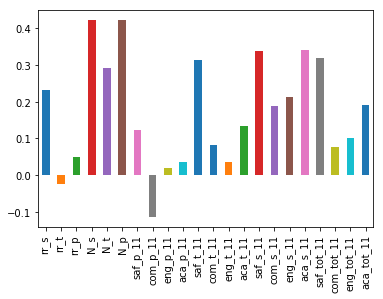

In [10]:
%matplotlib inline

# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

correlations.reindex(survey_fields).plot.bar()

In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. from the bar plot we can see that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score.

Let's investigate further into this relationship, and try to figure out which schools have low safety scores.

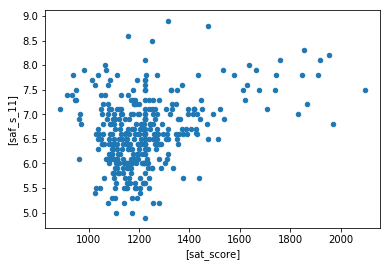

In [11]:
combined.plot.scatter(['sat_score'],['saf_s_11'])

From looking at the plot, we can see that there is a weak positive correlation between safety and SAT scores. This may imply that students find it easier to study when they don't fear for their safety.

Let's generate a basemap of NYC and see which schools have lower safety.

C:\Users\toksa\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\toksa\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


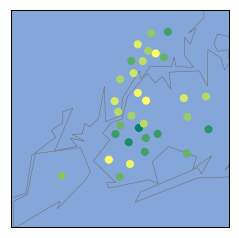

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace = True)

# This code snippet will create a map that centers on New York City
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# converts to list
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

# Generate a scatterplot
# s = 20 for size of points
# zorder = 2 for dots on top of the map
# latlon = True to indicate we are putting in latitude/longitude
#  We use the summer colormap, which results in green points for low numbers, and yellow points for high numbers.
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, c = districts['saf_s_11'], cmap = 'summer')

plt.show()

From viewing the map we just created we can see that the dark green dots are representative of low safety scores. The majority of these low scores are centered around the Brooklyn borough of New York. Brooklyn as a population of over 2.6 million and as of 2016, ~26% of its residents had income below the poverty line in 2016. This may result in increased crime rates which could lead to a percieved lack of safety in schools in this region.

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

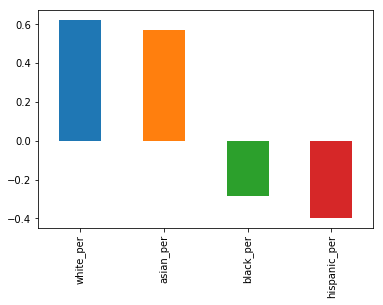

In [13]:
races = [ 'white_per','asian_per','black_per','hispanic_per',]

correlations[races].plot.bar()

From the bar plot, we see a positive correlation for white and asian individuals when it comes to SAT scores. However, a negative correlation is observed in relation to black/hispanic SAT scores. Let's investigate the hispanic further as it had a greater negative correlation. 

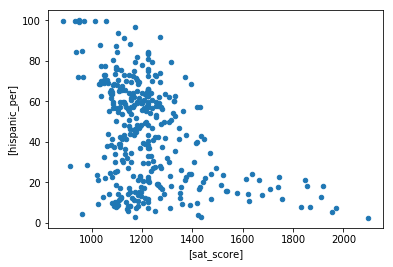

In [14]:
combined.plot.scatter(['sat_score'], ['hispanic_per'])

From the scatter plot above we can see that schools with a high amount of Hispanic students do poorly in the SATs compared to schools where the Hispanic population is lower. Let's filter the data down to scools with greater than 95% Hispanic students.

In [15]:
schools_with_hispanic_95 = combined[combined['hispanic_per'] > 95]
schools_with_hispanic_95

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135,"1,083,802","1,010,790,029",Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,107.419512,131.425,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269,"1,063,703","1,021,550,035",Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,0,0,0,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,"21,502","2,008,460","2,028,660,070",University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409,"2,015,241","2,032,470,070",Van Cortlandt Village ...,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,107.419512,131.425,...,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",9.000000,18.000000,56,"2,027,459","2,038,640,001",West Farms-Bronx River ...,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000,...,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",5.000000,37.000000,"1,180","3,090,738","3,040,940,001",park-cemetery-etc-Brooklyn ...,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,107.419512,131.425,...,"45 10 94Th Street\nElmhurst, NY 11373\n(40.743...",4.000000,25.000000,463,"4,437,166","4,016,000,061",Elmhurst ...,40.743303,-73.870575,24


From researching the schools with greater than 95% Hispanic students, it becomes evident that these schools offers immigrants, mostly those from Spanish speaking countries to complete High school. Examples of this are Pan American International High School at Monroe which offers new immigrants, mostly from rural areas of the Dominican Republic, the chance to learn English and complete high school or Washington Heights Expeditionary Learning School, where 98% of its students were either Hispanic and Latino. This may indicate that the majority of these students are ESL students which could explain their poor SAT scores. Now lets investigate schools with low Hispanic student enrollment.

In [16]:
schools_with_hispanic_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
schools_with_hispanic_10

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,107.419512,131.425,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,"31,703","1,084,587","1,000,160,215",Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,107.419512,131.425,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409,"2,094,706","2,032,510,201",Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,107.419512,131.425,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33,"3,058,752","3,020,980,013",Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.000000,338.000,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246,"4,215,611","4,100,990,052",Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.000000,905.000,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134,"5,107,621","5,042,440,001",New Dorp-Midland Beach ...,40.567913,-74.115362,31


The schools were the Hispanic students make up less than 10% of the students and where the average SAT scores are greater than 1800 are elite schools where students face a lot of competition for enrollment. An example of this is Stuyvesant High School, admission to Stuyvesant involves passing the Specialized High Schools Admissions Test. Each year, about 30,000 eighth and ninth-grade students take the three-hour test for admittance to eight of the nine specialised high schools. Around 900 to 950 applicants are accepted to Stuyvesant each year. All the schools mentioned above are all part of the nine specialised high schools in New York.

Now lets investigate the correlation between SAT scores and gender.

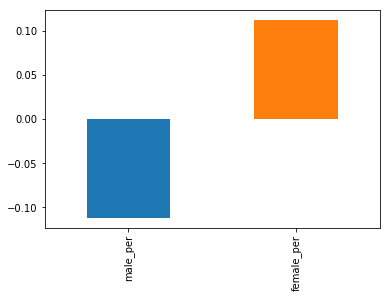

In [17]:
gender = ['male_per', 'female_per']

correlations[gender].plot.bar()

It seems that there is little to no correlation for both genders, females have a small positive correlation while males have a small negative correlation.

Let's investigate schools with high SAT scores and a high number of female students. 

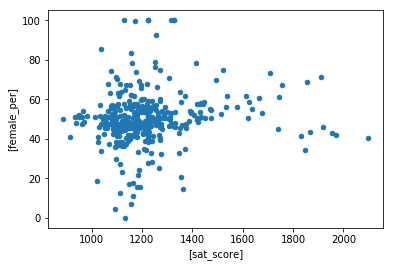

In [18]:
combined.plot.scatter(['sat_score'], ['female_per'])

The scater plot doesn't reveal much to us, there is not much correlation between schools with more female students and SAT scores.

We can further investigate this by filtering schools with greater than 60% females and higher than 1700 SAT scores

In [19]:
schools_with_females_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
schools_with_females_60

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,107.419512,131.425,...,"525 East Houston Street\nNew York, NY 10002\n(...",3.0,2.0,"1,002","1,004,062","1,003,250,025",Lower East Side ...,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000,...,"411 East 76 Street\nNew York, NY 10021\n(40.77...",8.0,5.0,132,"1,045,949","1,014,710,005",Lenox Hill-Roosevelt Island ...,40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000,...,"227 243 West 61St Street\nNew York, NY 10023\n...",7.0,6.0,151,"1,030,328","1,011,540,108",Lincoln Square ...,40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,131.425,...,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151,"1,030,341","1,011,560,030",Lincoln Square ...,40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000,...,"149 11 Melbourne Avenue\nFlushing, NY 11367\n(...",8.0,24.0,809,"4,538,714","4,065,070,200",Kew Gardens Hills ...,40.734408,-73.821417,25


From researching the schools in the dataframe above we can see that some of these schools are some of the best in New York City. Fiorello H Laguardia High School is ranked 26th, Townsend Harris High School is ranked 7th and Eleanor Roosevelt High School is ranked 19th in NYC for 2018. These are some of the tops schools in New York and it is understandable the SAT scores are high as they have the ability to attract some of the best students.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects. It would make sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. To examine this relationship we will look at the percentage of students in each school who took at least one AP exam.

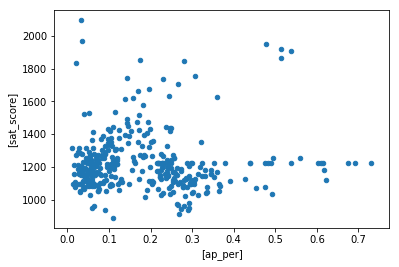

In [20]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter(['ap_per'],['sat_score'])

From examining the plot, it doesn't seem that there is much correlation between the percentage of AP test takers and SAT scores. This might be because there are AP exams are for many different subjects while the SAT's are focused around a reading test, writing & language test and a mathematics test. Also on most AP tests, you can still earn a 5 if you get a fair amount of questions wrong, whereas there’s almost no room for error on SAT tests if you want a perfect score.